Plotting a Muon Spectrum with `panama`
======================================

This notebook showcases how to read in a muon spectrum in panama and plot it.
For that you have to have some CORSIKA7 DAT files, for example use the ones provided in `panama`s test folder.

In [1]:
# These modules will be used
import numpy as np
import matplotlib.pyplot as plt

import panama as pn
import fluxcomp

# To convert PDG IDs to particle names
from particle import Particle

In [2]:
# Load the full dataset
run_header, event_header, particles = pn.read_DAT(
    glob="../../tests/files/DAT*", mother_columns=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900.0 [00:00<00:00, 18677.23it/s]


**Tip**:
This dataset is very small, but for larger datasets it might be useful to load in the DAT files using `panama` and 
then exporting them to `hdf` using e.g. `particles.to_hdf`, since this format should be faster. You can additionally drop information you don't need.
To do this from the command line, `panama` provides the command `panama hdf5`.

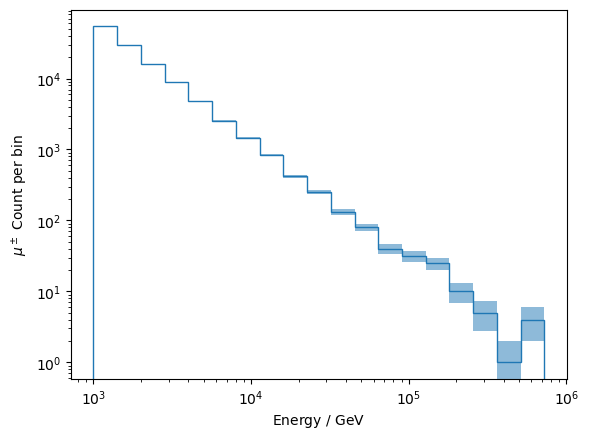

In [3]:
# Select all muons and anti-muons and histogram their energy
e = particles.query("pdgid in (13, -13)")["energy"]

# Create new plot
fig, ax = plt.subplots()

# Use logarithmically sized bins
bins = np.geomspace(e.min(), e.max(), 20)

# Get the counts in each bin
counts, _ = np.histogram(e, bins=bins)

# Plot hist and error bands
ax.stairs(
    counts,
    bins,
)
ax.fill_between(
    bins[1:], counts - np.sqrt(counts), counts + np.sqrt(counts), step="pre", alpha=0.5
)

# Add information and double log
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Energy / $\mathrm{GeV}$")
ax.set_ylabel("$\mu^\pm$ Count per bin")
None

This histogram does not yet relate to a flux, as it is only a count and the simulation has to be weighted.
The falling spectrum with $E^{-1}$ in the plot above indicates the simulation spectral index was $-1$.

So let's add weights to the simulation now!

In [4]:
particles["weight_GSF"] = pn.get_weights(
    run_header,
    event_header,
    particles,
    model=fluxcomp.GlobalSplineFit(),
    proton_only=True,
)
particles["weight_GST"] = pn.get_weights(
    run_header, event_header, particles, model=fluxcomp.GlobalFitGST(), proton_only=True
)

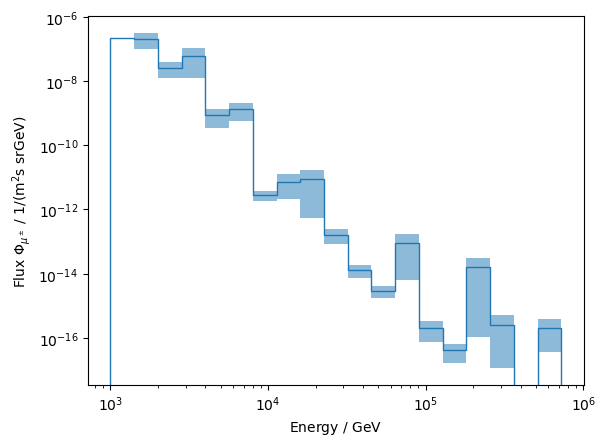

In [5]:
# Select all muons and anti-muons and histogram their energy
sel = particles.query("pdgid in (13, -13)")
e = sel["energy"]

# Create new plot
fig, ax = plt.subplots()

# Use logarithmically sized bins
bins = np.geomspace(e.min(), e.max(), 20)

# Get the weighted counts (=flux) in each bin
flux, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"])
# The error for weighted histograms calculates as follows
err, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"] ** 2)
err = np.sqrt(err)

# The differential flux is more informative, so we convert to that
flux /= np.diff(bins)
err /= np.diff(bins)

# Plot hist and error bands
ax.stairs(
    flux,
    bins,
)
ax.fill_between(bins[1:], flux - err, flux + err, step="pre", alpha=0.5)

# Add information and double log
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Energy / $\mathrm{GeV}$")
ax.set_ylabel("Flux $\Phi_{\mu^\pm}\ /\ 1/(\mathrm{m^2 s\ sr GeV})$")
None

Now we have a weighted, physical spectrum!
Keep in mind that while now we see a falling spectrum with approximately $E^{-(3..4)}$, the simulation is very limited and in reality not usable for plotting a muon spectrum. 
As an exercise, you can try to reproduce the same plot, but with the weights from the `GST` model, above.

## Making use of the `EHIST` Option
Since the simulation was performed using `CORSIKA7`'s `EHIST` option, we can now divide the muons by their parent-particles. 
Let's see what parent particles are available.

Text(0.5, 0, 'Parent Particle')

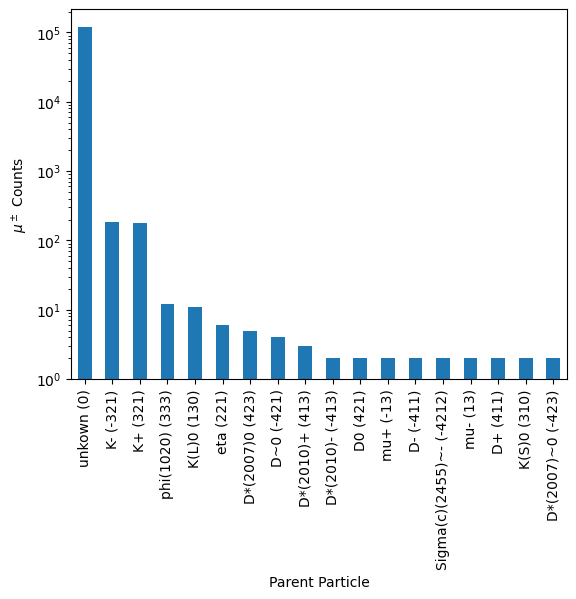

In [6]:
sel = particles.query("pdgid in (13, -13)")

counts = sel.mother_pdgid_cleaned.value_counts()
counts.index = counts.index.map(
    lambda pid: (
        f"{Particle.from_pdgid(pid).name} ({pid})" if pid != 0 else "unknown (0)"
    )
)
counts.plot(kind="bar", log=True)

plt.ylabel("$\mu^\pm$ Counts")
plt.xlabel("Parent Particle")

We see that most of the mother particles are "unknown".
These unknown particles are assumed to be always pions or (more rarely) kaons.
This is due to the limitations of `CORSIKA7`'s `EHIST` option.
With `EHIST`, sometimes the provided so-called "mother" particle is not really the direct parent of the 
muon; instead, it's some particle before the observation-level muon in thedecay-chain.
This can be parsed using the "Hadron Generation Counter" provided by the CORSIKA7 output. 
`PANAMA` automatically corrects for that in the "cleaned" columns. 

TLDR; Due to quirks in CORSIKA7, "unknown" are all the pions which can't be further distinguished.

Let's plot only the spectrum of the muons coming from $D$-Meson decays, which makes up a huge part of the so-called "prompt" spectrum.

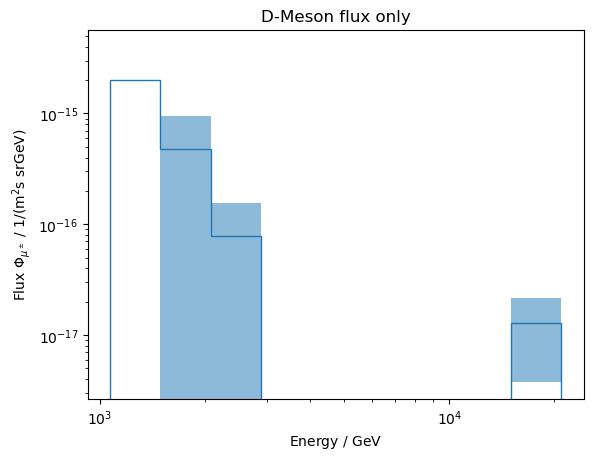

In [7]:
# Select all muons and anti-muons and histogram their energy
sel = particles.query(
    "pdgid in (13, -13) and mother_pdgid_cleaned in (423, 421, 413, -413, 421, -411, 411)"
)
e = sel["energy"]

# Create new plot
fig, ax = plt.subplots()

# Use logarithmically sized bins
bins = np.geomspace(e.min(), e.max(), 10)

# Get the weighted counts (=flux) in each bin
flux, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"])
# The error for weighted histograms calculates as follows
err, _ = np.histogram(e, bins=bins, weights=sel["weight_GSF"] ** 2)
err = np.sqrt(err)

# The differential flux is more informative, so we convert to that
flux /= np.diff(bins)
err /= np.diff(bins)

# Plot hist and error bands
ax.stairs(flux, bins)
ax.fill_between(bins[1:], flux - err, flux + err, step="pre", alpha=0.5)

# Add information and double log
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Energy / $\mathrm{GeV}$")
ax.set_ylabel("Flux $\Phi_{\mu^\pm}\ /\ 1/(\mathrm{m^2 s\ sr GeV})$")
ax.set_title("D-Meson flux only")
None

Obviously, for this plot to make sense, you need a larger simulation set.